## Dataset Overview
HAM10000 ("Human Against Machine with 10000 training images") dataset - a large collection of multi-source dermatoscopic images of pigmented lesions

The dermatoscopic images are collected from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images.

It has 7 different classes of skin cancer which are listed below :
- Melanocytic nevi
- Melanoma
- Benign keratosis-like lesions
- Basal cell carcinoma
- Actinic keratoses
- Vascular lesions
- Dermatofibroma 

## Importing libraries

In [84]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold

import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Activation, BatchNormalization
from sklearn.metrics import classification_report, accuracy_score


## Reading the Data

In [85]:
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


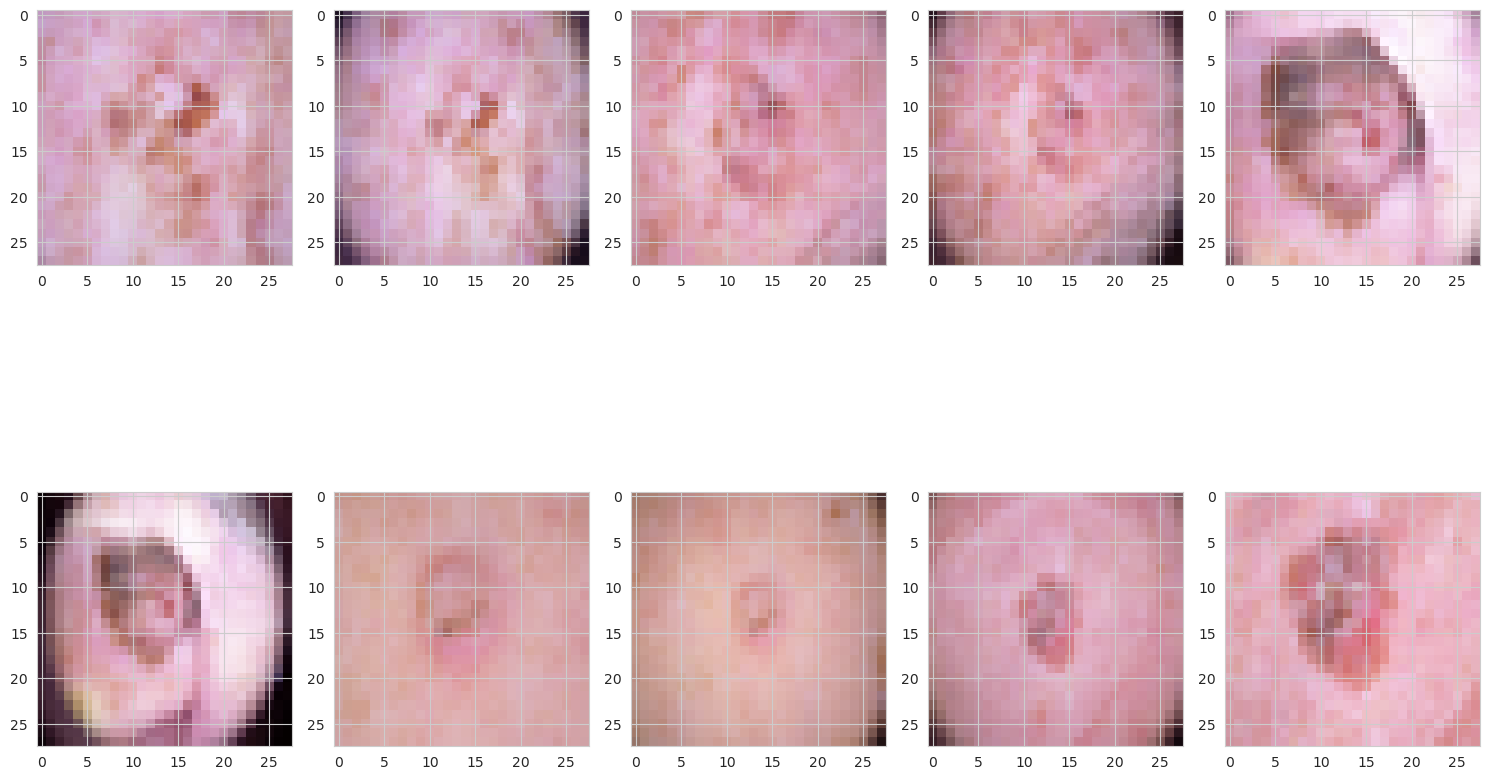

In [86]:
f , ax = plt.subplots(2,5)
f.set_size_inches(15, 15)
k = 0
y1 = data['label']
x1 = data.drop(columns = ['label'])
x1= np.array(x1).reshape(-1,28,28,3)
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x1[k].reshape(28,28,3))
#         ax[i, j].set_title(f"Image {Y_train[4]}")
        k = k + 1
    plt.tight_layout()

## Data Preprocessing
## Data Cleaning

In [87]:
data['label'].unique()
y = data['label']
x = data.drop(columns = ['label'])
data.isnull().sum().sum() #no null values present

0

In [88]:
meta_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [89]:
meta_data['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [90]:
data.isnull().sum().sum() #no null values present
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Exploratory Data Analysis

Text(0.5, 1.0, 'Frequency Distribution of Classes')

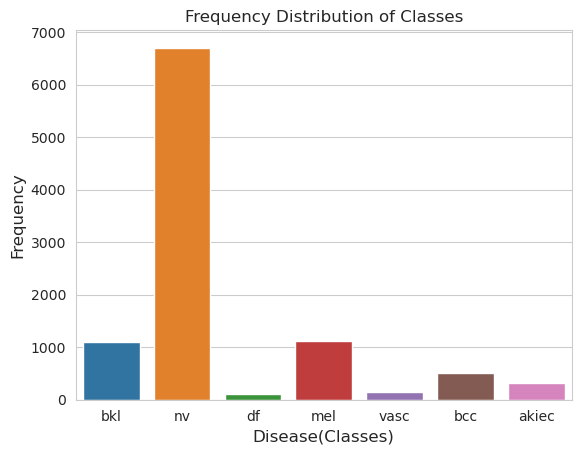

In [91]:
sns.countplot(x = 'dx', data = meta_data)
plt.xlabel('Disease(Classes)', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes')

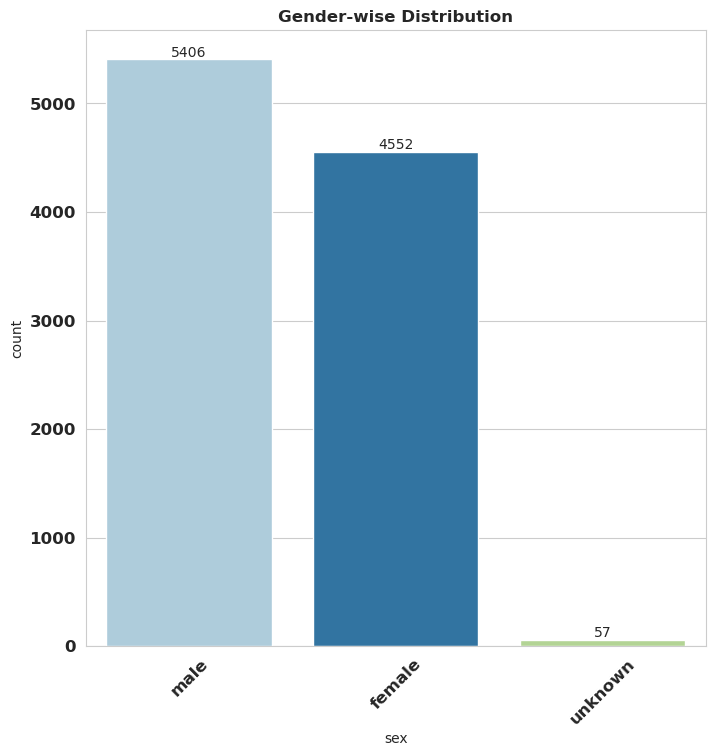

In [92]:
sns.set_style('whitegrid')
colors = ['#87ace8','#e3784d', 'green']
fig,axes = plt.subplots(figsize=(8,8))

ax = sns.countplot(x='sex',data=meta_data, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender-wise Distribution',fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.show()

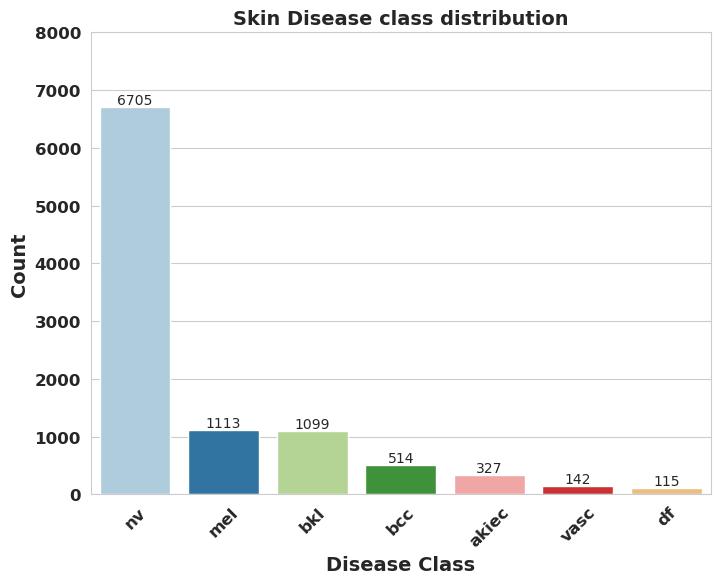

In [93]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(8,6))
ax = sns.countplot(x='dx',data=meta_data, order = meta_data['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Skin Disease class distribution',fontweight='bold',fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 8000)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Disease Class", fontweight='bold', fontsize=14)
plt.show()

In [94]:
classes = {2:'bkl', 4:'nv', 3:'df', 6:'mel', 5:'vasc', 1:'bcc', 0:'akiec'}

classes_labels=[]
for key in classes.keys():
    classes_labels.append(key)
print(classes_labels)

[2, 4, 3, 6, 5, 1, 0]


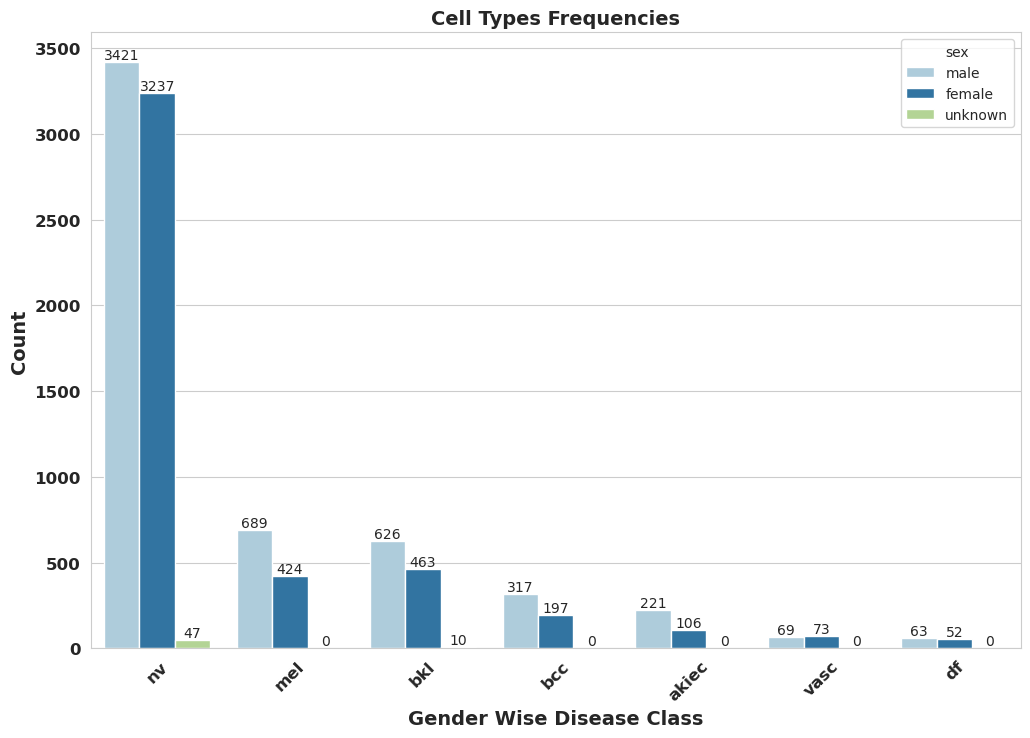

In [95]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx',hue='sex', data=meta_data, order = meta_data['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies',fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Gender Wise Disease Class", fontweight='bold', fontsize=14)
plt.show()

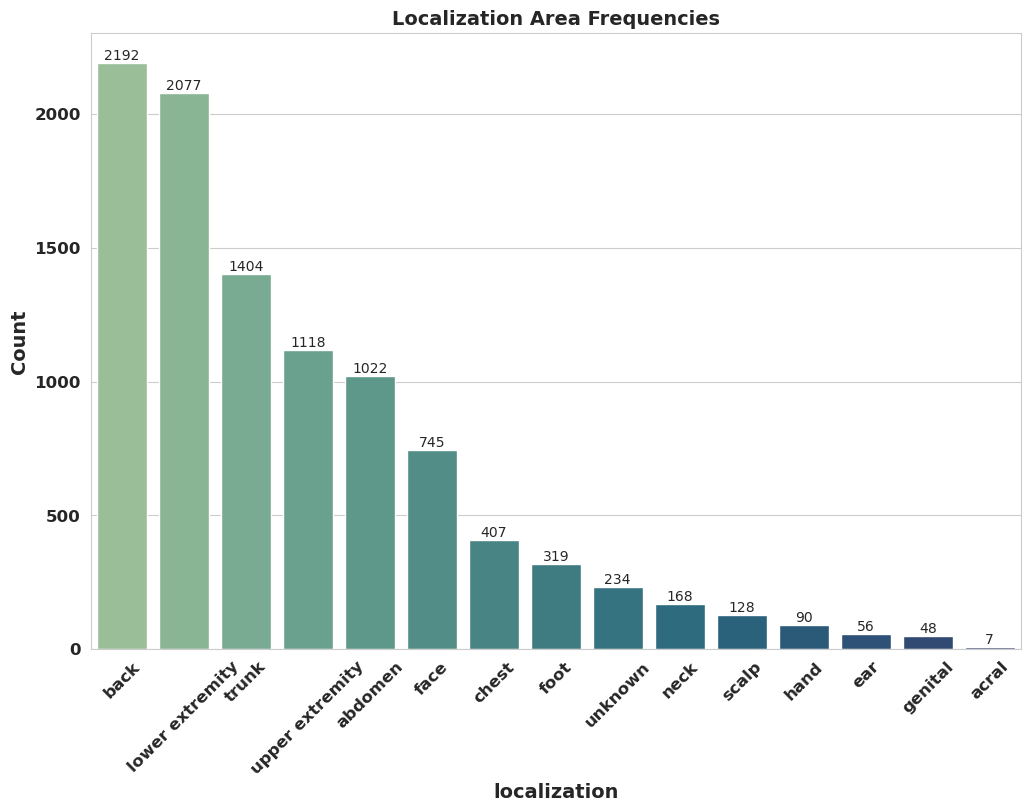

In [96]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',data=meta_data, order = meta_data['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies',fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("localization", fontweight='bold', fontsize=14)
plt.show()

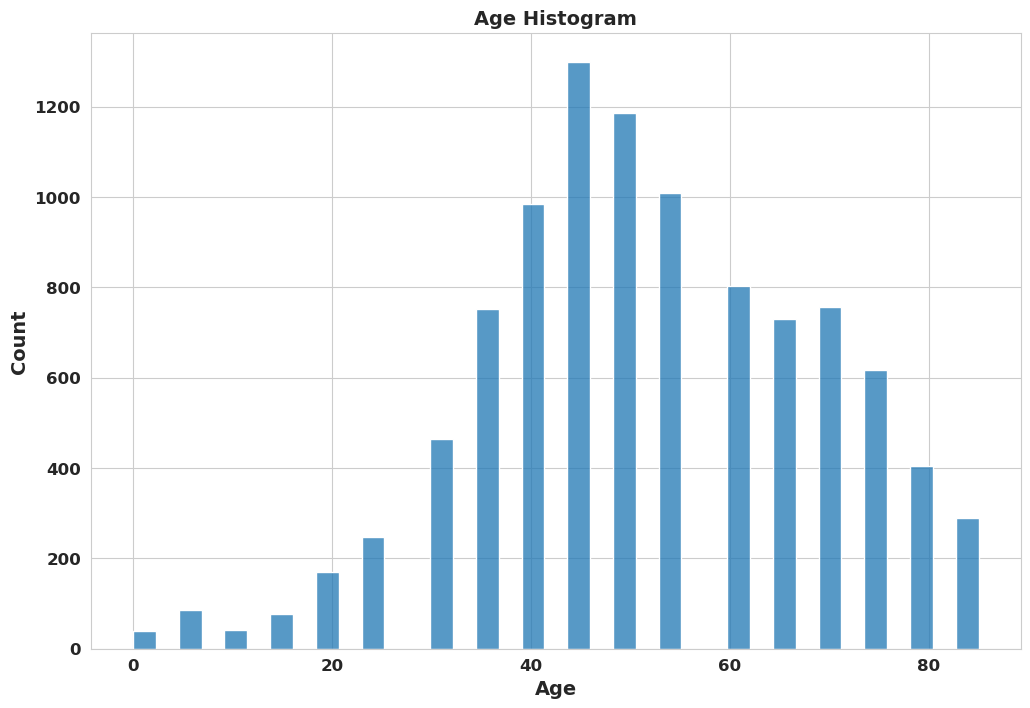

In [97]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=meta_data, x='age')
plt.title('Age Histogram',fontweight='bold', fontsize=14)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Age", fontweight='bold', fontsize=14)
plt.show()

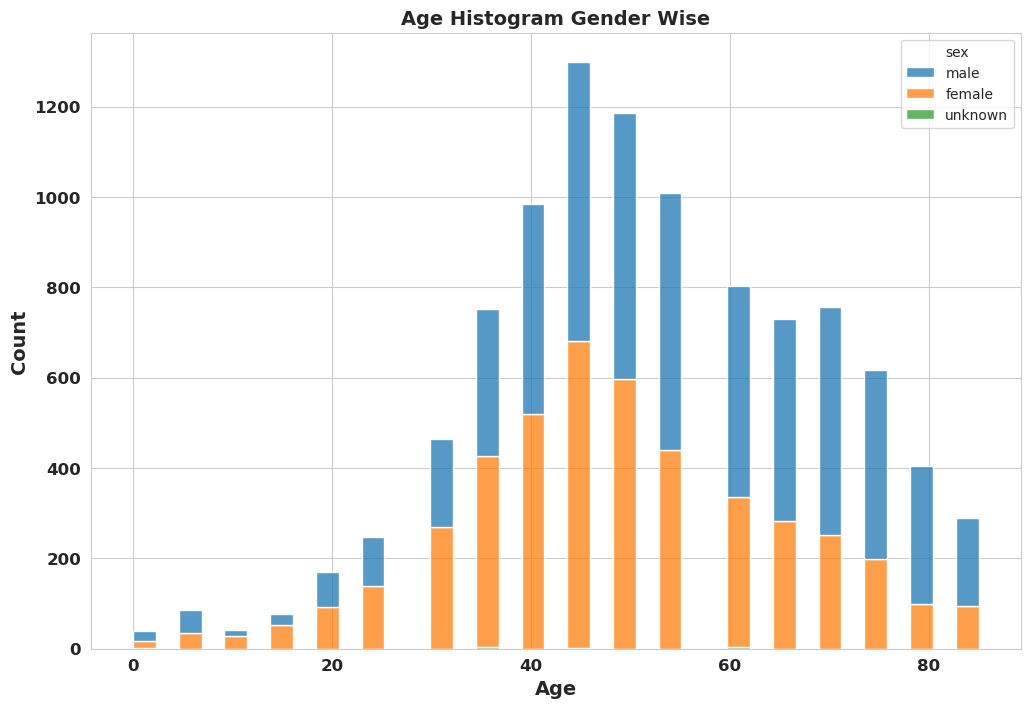

In [98]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=meta_data, x='age',hue='sex',multiple='stack')
plt.title('Age Histogram Gender Wise',fontweight='bold', fontsize=14)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Age", fontweight='bold', fontsize=14)
plt.show()

In [40]:
# Splitting Data
print(x.shape,y.shape)
x1, X_test, y1, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)
print(y1.shape,x1.shape)
print(X_test.shape , Y_test.shape)

(10015, 2352) (10015,)
(8012,) (8012, 2352)
(2003, 2352) (2003,)


In [99]:
print(x1.shape,y1.shape)
# To overcome class imbalace
oversample = RandomOverSampler()
Data,Label  = oversample.fit_resample(x,y)
print(Data.shape,Label.shape)

(10015, 28, 28, 3) (10015,)
(46935, 2352) (46935,)


In [100]:
# Splitting Data
print(Data.shape,Label.shape)
x1, X_test_d, y1, Y_test_d = train_test_split(Data,Label, test_size=0.2, random_state=1)
print(y1.shape,x1.shape)
print(X_test_d.shape , Y_test_d.shape)

(46935, 2352) (46935,)
(37548,) (37548, 2352)
(9387, 2352) (9387,)


In [104]:
# reshaping the data so that it can be taken by convolution neural network(without disturbing the no. of samples)
d=x1
x1= np.array(x1).reshape(-1,28,28,3)
print('Shape of X :',x1.shape)
print('Shape of y :',y1.shape)

Shape of X : (37548, 28, 28, 3)
Shape of y : (37548,)


In [105]:
print(y1)

18033    1
38412    5
26590    2
6910     4
37704    5
        ..
43723    6
32511    3
5192     4
12172    0
33003    3
Name: label, Length: 37548, dtype: int64


In [106]:
newLabel = []

for i in range(len(y1)):
    for key in classes.keys():
        if Label[i] == key:
            newLabel.append(classes[key])



In [112]:
df = pd.DataFrame({'newLabel': newLabel})


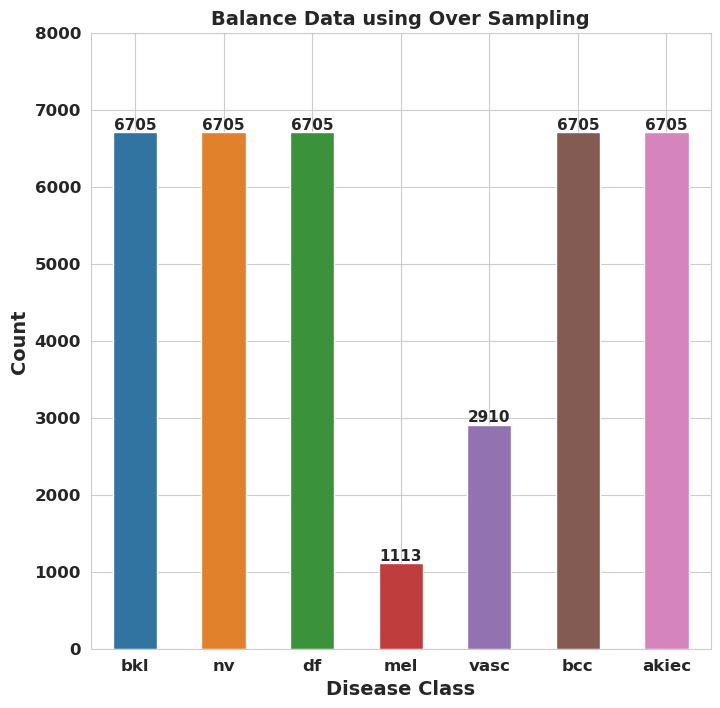

In [113]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(8,8))
ax = sns.countplot(x=newLabel,data=df,width=0.5)
for container in ax.containers:
    ax.bar_label(container, fontweight='bold', fontsize=11)
plt.title('Balance Data using Over Sampling', fontweight='bold', fontsize=14)
plt.ylim(0, 8000)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Disease Class", fontweight='bold', fontsize=14)

plt.grid(linewidth=0.8)
plt.show()

In [114]:
x1 = np.array(x1).reshape(-1,28,28,3)
print('Shape of X :',x1.shape)
print('Shape of y :',y1.shape)

Shape of X : (37548, 28, 28, 3)
Shape of y : (37548,)


In [28]:
# index = range(len(X_test))
# YY_test = pd.Series(Y_test.values, index=index)
# import numpy as np
# import os
# from PIL import Image

# # Create the test_images directory
# if not os.path.exists('test_images'):
#     os.mkdir('test_images')

# # Loop through each test example
# for i in range(len(X_test)):
#     # Get the pixel values and convert them to integers
#     pixels = X_test[i].astype('uint8')

#     # Get the label
#     label = YY_test[i]

#     # Create a new image from the pixel values
#     img = Image.fromarray(pixels)

#     # Save the image to a file
#     filename = f"{label}_{i}.png"
#     img.save(os.path.join('test_images', filename))


In [31]:
# import numpy as np
# import os

# # Define the epsilon value
# epsilon_1 = 0.1

# # Apply adversarial noise to each image in X_test
# X_test_ADN_0_1 = X_test + epsilon * np.sign(np.random.randn(*X_test.shape))

# # Clip the pixel values to the valid range of [0, 1]
# X_test_ADN_0_1 = np.clip(X_test_ADN_0_1, 0, 1)

# # # Save the new data to a CSV file
# # np.savetxt('X_test_ADN_0.1.csv', X_test_ADN_0_1, delimiter=',')

# # Create a new directory to store the images
# if not os.path.exists('test_ADN_0.1'):
#     os.makedirs('test_ADN_0.1')

# # Save each image in X_test_ADN_0_1 to the new directory
# for i in range(len(X_test)):
#     # Create a new image from the pixel values
#     img = X_test_ADN_0_1[i].reshape((28, 28, 3))
    
#     # Get the label
#     label = Y_test.iloc[i]
    
#     # Save the image to the new directory
#     filename = f'test_ADN_0.1/image_{i}_label_{label}.png'
#     plt.imsave(filename, img)


(9387, 28, 28, 3)

In [115]:
classes = {4:'melanocytic nevi',
6: 'melanoma',
2:'benign keratosis-like lesions',
1:'basal cell carcinoma',
5:'pyogenic granulomas and hemorrhage',
0:'Actinic keratoses and intraepithelial carcinomae',
3:'dermatofibroma'}


In [116]:
y1[:10]

18033    1
38412    5
26590    2
6910     4
37704    5
15663    0
31556    3
45531    6
24641    2
44902    6
Name: label, dtype: int64

In [117]:
l_train = np.array(y1)
l_train[1]

5

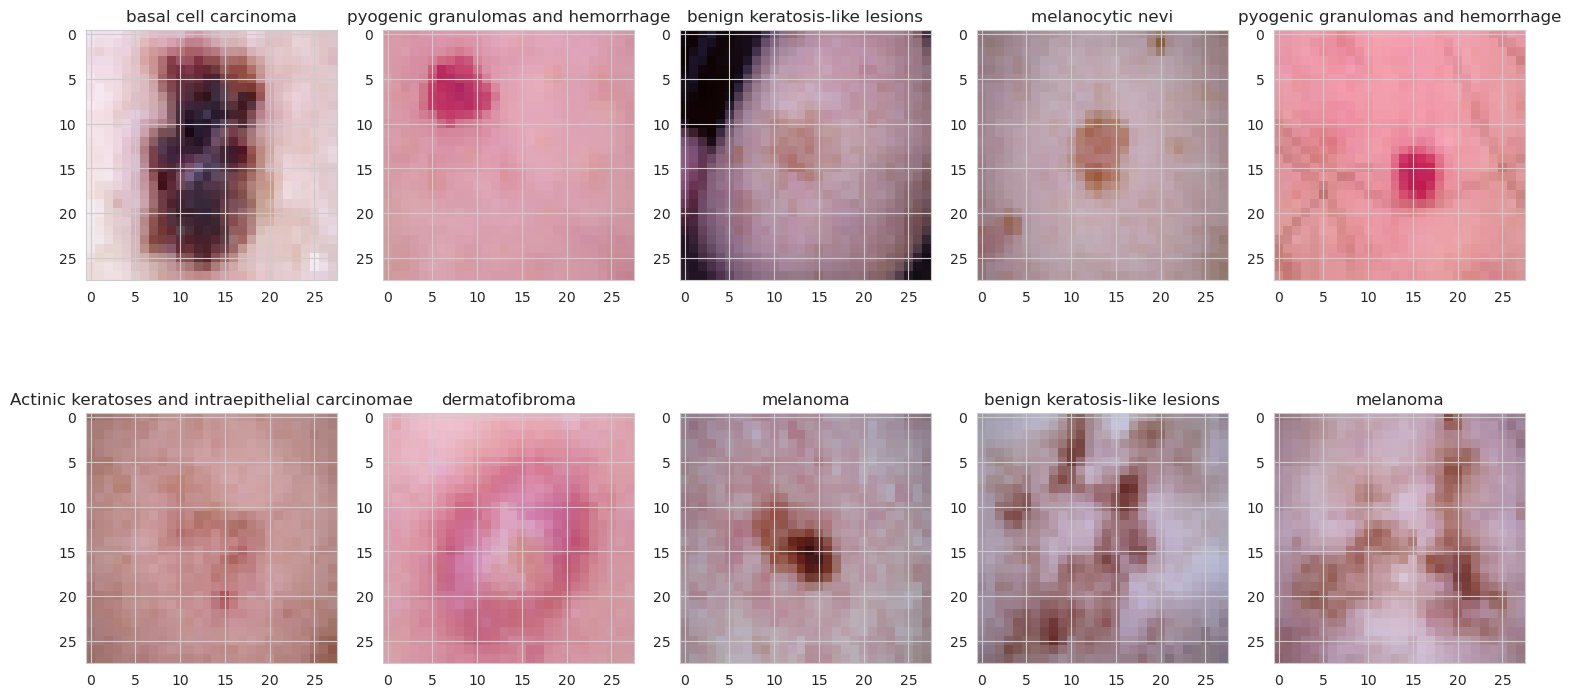

In [118]:
f , ax = plt.subplots(2,5)
f.set_size_inches(15, 15)
k = 0
l_train = np.array(y1)
for i in range(2):
    for j in range(5):
        plt.subplots_adjust(wspace=5)
        ax[i,j].imshow(x1[k].reshape(28,28,3))
        ax[i, j].set_title(f"{classes[l_train[k]]}")
        k = k + 1
   
    plt.tight_layout()

In [119]:
model_CNN = Sequential()
model_CNN.add(Conv2D(32, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())


model_CNN.add(MaxPool2D(pool_size = (2,2)))


model_CNN.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())

model_CNN.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model_CNN.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())

model_CNN.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

model_CNN.add(Flatten())


model_CNN.add(Dense(64, activation = 'relu'))
model_CNN.add(BatchNormalization())


model_CNN.add(Dense(32))
model_CNN.add(Activation(activation='relu'))
model_CNN.add(BatchNormalization())

model_CNN.add(Dense(16))
model_CNN.add(Activation(activation='relu'))
model_CNN.add(BatchNormalization())

model_CNN.add(Dense(7))
model_CNN.add(Activation(activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model_CNN.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
print(model_CNN.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

In [120]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
history = model_CNN.fit(x1,
                    y1,
                    validation_split=0.2,
                    batch_size = 64,
                    epochs = 50,
                    callbacks = [reduce_lr, early_stop])

Epoch 1/50
470/470 [==============================] - 9s 10ms/step - loss: 0.9023 - accuracy: 0.6813 - val_loss: 1.1168 - val_accuracy: 0.5995 - lr: 0.0010
Epoch 2/50
470/470 [==============================] - 4s 8ms/step - loss: 0.3920 - accuracy: 0.8653 - val_loss: 0.5311 - val_accuracy: 0.8121 - lr: 0.0010
Epoch 3/50
470/470 [==============================] - 4s 8ms/step - loss: 0.2425 - accuracy: 0.9142 - val_loss: 0.2892 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 4/50
470/470 [==============================] - 4s 8ms/step - loss: 0.1870 - accuracy: 0.9338 - val_loss: 0.2664 - val_accuracy: 0.9009 - lr: 0.0010
Epoch 5/50
470/470 [==============================] - 4s 9ms/step - loss: 0.1392 - accuracy: 0.9516 - val_loss: 0.4764 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 6/50
470/470 [==============================] - 4s 9ms/step - loss: 0.1034 - accuracy: 0.9636 - val_loss: 0.5966 - val_accuracy: 0.8103 - lr: 0.0010
Epoch 7/50
466/470 [============================>.] - ETA: 0s - loss:

In [121]:
X_test = np.array(X_test).reshape(-1,28,28,3)


In [122]:
results = model_CNN.evaluate(X_test , Y_test, verbose=0)

print("CNN Model Test Results")
print("        Test Loss: {:.5f}".format(results[0]))
print("    Test Accuracy: {:.2f}%".format(results[1] * 100))

CNN Model Test Results
        Test Loss: 0.10389
    Test Accuracy: 97.40%


In [80]:
import tensorflow as tf

def generate_adversarial_noise(X_test, Y_test, model, epsilon):
     # Create a directory for the adversarial images
    if not os.path.exists(f"test_ADN_{epsilon}"):
        os.mkdir(f"test_ADN_{epsilon}")


    # Create a copy of the input image
    X_test_adn = X_test.copy()

    # Set the input tensor to be trainable
    X_test_adn = tf.Variable(X_test_adn, dtype=tf.float32)

    # Create a one-hot encoding of the target label
    Y_test_onehot = tf.one_hot(Y_test, depth=7)

    # Calculate the gradients of the loss with respect to the input
    with tf.GradientTape() as tape:
        prediction = model(X_test_adn)
        loss = tf.keras.losses.categorical_crossentropy(Y_test_onehot, prediction)
    gradients = tape.gradient(loss, X_test_adn)

    # Get the sign of the gradients
    signed_gradients = tf.sign(gradients)

    # Add the noise to the image
    X_test_adn.assign_add(epsilon * signed_gradients)

    # Clip the image to the valid pixel range
    X_test_adn = tf.clip_by_value(X_test_adn, 0, 255)
    

    # Convert the tensor back to a numpy array
    X_test_adn = X_test_adn.numpy()
    
        # Loop through each image in the test set
    for i in range(len(X_test_adn)):
        # Get the pixel values of the image
        pixels = X_test_adn[i]
        label = Y_test.iloc[i]

        # Save the noisy image to the new directory
        cv2.imwrite(f"test_ADN_{epsilon}/{i}_{label}.png", pixels)

    return X_test_adn


In [89]:
X_text_noise_01=generate_adversarial_noise(X_test, Y_test, model_CNN, 0.1)
X_text_noise_02=generate_adversarial_noise(X_test, Y_test, model_CNN, 0.2)
X_text_noise_03=generate_adversarial_noise(X_test, Y_test, model_CNN, 0.3)
X_text_noise_04=generate_adversarial_noise(X_test, Y_test, model_CNN, 0.4)
X_text_noise_05=generate_adversarial_noise(X_test, Y_test, model_CNN, 0.5)
X_text_noise_06=generate_adversarial_noise(X_test, Y_test, model_CNN, 0.6)
X_text_noise_07=generate_adversarial_noise(X_test, Y_test, model_CNN, 0.7)
X_text_noise_08=generate_adversarial_noise(X_test, Y_test, model_CNN, 0.8)
X_text_noise_09=generate_adversarial_noise(X_test, Y_test, model_CNN, 0.9)
X_text_noise_10=generate_adversarial_noise(X_test, Y_test, model_CNN, 1)

ALL_test_datasets=[X_test,X_text_noise_01,X_text_noise_02,X_text_noise_03,X_text_noise_04,X_text_noise_05,X_text_noise_06,X_text_noise_07,X_text_noise_08,X_text_noise_09,X_text_noise_10]


In [90]:
def evaluate(X_test_noise,Y_test):
    
    results = model_CNN.evaluate(X_test_noise , Y_test, verbose=0)
    return results


In [95]:
for i in range(11):
    res=evaluate(ALL_test_datasets[i],Y_test)
    print(f"Test on {i}")
    print("        Test Loss: {:.5f}".format(res[0]))
    print("    Test Accuracy: {:.2f}%".format(res[1] * 100))



Test on 0
        Test Loss: 0.07703
    Test Accuracy: 98.05%
Test on 1
        Test Loss: 0.12609
    Test Accuracy: 97.09%
Test on 2
        Test Loss: 0.19920
    Test Accuracy: 95.71%
Test on 3
        Test Loss: 0.33412
    Test Accuracy: 91.69%
Test on 4
        Test Loss: 0.59530
    Test Accuracy: 82.51%
Test on 5
        Test Loss: 1.01500
    Test Accuracy: 69.49%
Test on 6
        Test Loss: 1.56533
    Test Accuracy: 55.12%
Test on 7
        Test Loss: 2.19294
    Test Accuracy: 44.42%
Test on 8
        Test Loss: 2.83853
    Test Accuracy: 36.86%
Test on 9
        Test Loss: 3.47043
    Test Accuracy: 30.38%
Test on 10
        Test Loss: 4.07637
    Test Accuracy: 25.92%


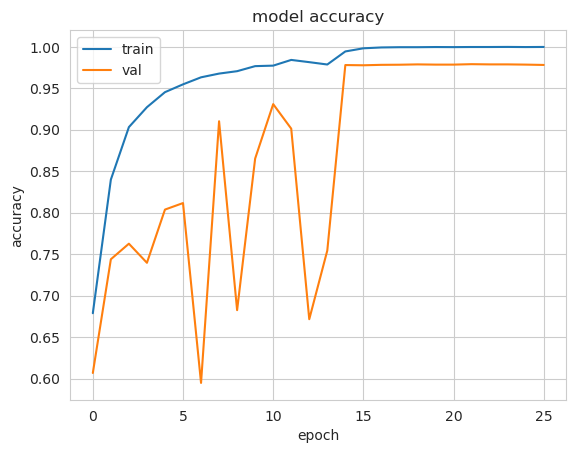

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

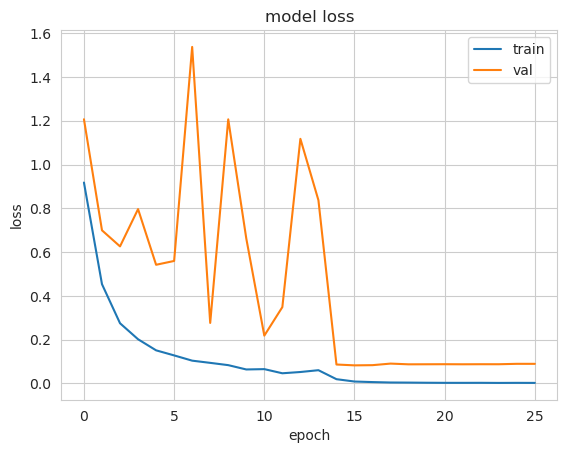

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [33]:
from sklearn.metrics import confusion_matrix , classification_report

y_true_CNN = list(Y_test)
y_pred_CNN = model_CNN.predict(X_test)
y_pred_CNN = list(map(lambda x: np.argmax(x), y_pred_CNN))
print("Predicting First Ten Rows:")
print('Y Actual Values :' , y_true_CNN[0:10])
print('Y Predicted Values :' , y_pred_CNN[0:10])

294/294 [==============================] - 1s 2ms/step
Predicting First Ten Rows:
Y Actual Values : [5, 1, 4, 0, 5, 0, 2, 0, 3, 2]
Y Predicted Values : [5, 1, 4, 0, 5, 0, 2, 0, 3, 2]


[[1256    3    0    3    0    0    0]
 [  66 1208    3   86    0    9    2]
 [   0    0 1351    0    0    0    0]
 [  13    8    0 1343    0    0    1]
 [   0    0    0    0 1358    0    0]
 [   0    0    0    0    0 1318    0]
 [   0    0    0    0    0    0 1359]]


<AxesSubplot:>

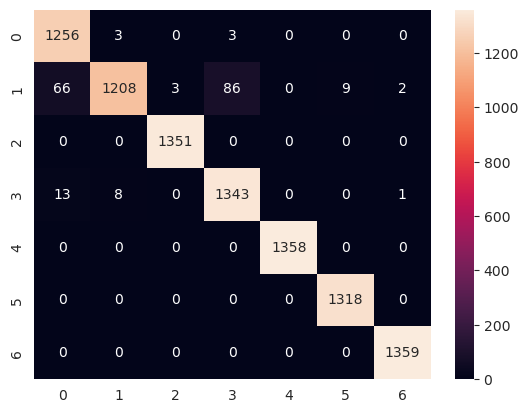

In [34]:
cm_CNN = confusion_matrix(y_true_CNN,y_pred_CNN,labels=classes_labels)
print(confusion_matrix(y_true_CNN,y_pred_CNN,labels=classes_labels))
sns.heatmap(cm_CNN, annot = True, fmt='')

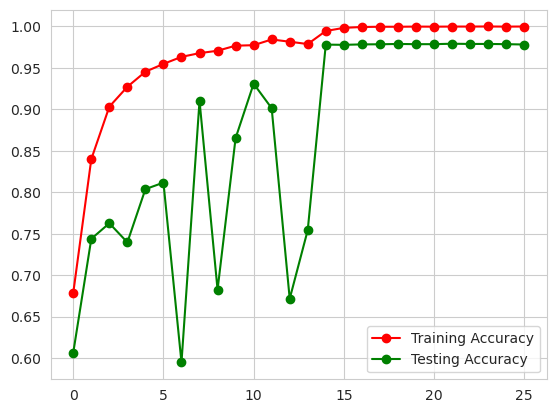

In [35]:
#training acc vs testing acc graph
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

In [36]:
#predicting
y_pred_CNN  = model_CNN.predict(X_test)
target_names = [f"{classes[i]}" for i in range(7)]
y_pred_CNN = list(map(lambda x: np.argmax(x), y_pred_CNN))
print("CNN Model Prediction Results")
print(classification_report(Y_test , y_pred_CNN,target_names=target_names))

294/294 [==============================] - 1s 2ms/step
CNN Model Prediction Results
                                                  precision    recall  f1-score   support

Actinic keratoses and intraepithelial carcinomae       1.00      1.00      1.00      1359
                            basal cell carcinoma       0.99      1.00      1.00      1318
                   benign keratosis-like lesions       0.94      1.00      0.97      1262
                                  dermatofibroma       1.00      1.00      1.00      1351
                                melanocytic nevi       0.99      0.88      0.93      1374
              pyogenic granulomas and hemorrhage       1.00      1.00      1.00      1358
                                        melanoma       0.94      0.98      0.96      1365

                                        accuracy                           0.98      9387
                                       macro avg       0.98      0.98      0.98      9387
              

In [37]:
# Layers definitions
from keras import backend as K
for l in range(len(model_CNN.layers)):
    print(l, model_CNN.layers[l])

0 <keras.layers.convolutional.conv2d.Conv2D object at 0x7175b5ea7ed0>
1 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7175a15528d0>
2 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7175b5ef0b50>
3 <keras.layers.convolutional.conv2d.Conv2D object at 0x7175b5ebe790>
4 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7175b5ee2150>
5 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x71762514bfd0>
6 <keras.layers.convolutional.conv2d.Conv2D object at 0x7175b559fed0>
7 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7175b58d18d0>
8 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7175b59ea4d0>
9 <keras.layers.reshaping.flatten.Flatten object at 0x7175b584f190>
10 <keras.layers.core.dense.Dense object at 0x7175b57a2590>
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7175b555de90>
12 <keras.layers.core.dense.Dense object at 0x7175

In [38]:
model_CNN.layers[-2]

In [39]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


## Separating Features Layers from the CNN Model

In [40]:
import tensorflow as tf
# feature_extractor = tf.keras.Model(inputs=model_CNN.input, 
#                                     outputs=model_CNN.get_layer(-2).output)
# output_layers_model =tf.keras.Model(inputs=model_CNN.input, outputs=model_CNN.output)
# cnn_layer_output = model_CNN.layers[-2].output
# cnn_model_features = tf.keras.Model(inputs=model_CNN.input, outputs=cnn_layer_output)
cnn_model_features = tf.keras.Model(inputs=model_CNN.input, outputs=model_CNN.layers[-3].output)


## Extracting Features from CNN Model

In [41]:
# Extract features from input data using the CNN model
X_train_cnn = cnn_model_features.predict(X_train)
X_test_cnn = cnn_model_features.predict(X_test)

294/294 [==============================] - 1s 2ms/step


## Integrating CNN with SVM Classifier using Grid Search for Best Perameters

In [42]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

clf=SVC(kernel='rbf',C=100,gamma=0.001)
kf=KFold(n_splits=5)
scores_SVM = cross_val_score(clf, X_train_cnn, Y_train, cv=kf)
print(scores_SVM)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_SVM.mean(), scores_SVM.std()))
clf.fit(X_train_cnn, Y_train)
# Evaluate the combined CNN-SVM model on a test dataset
svm_accuracy = clf.score(X_test_cnn, Y_test)
print('SVM Accuracy:', svm_accuracy*100)
y_testSVM = clf.predict(X_test_cnn)

[1.         0.99986684 1.         0.99986683 0.98162205]
1.00 accuracy with a standard deviation of 0.01
SVM Accuracy: 98.57249387450729


In [43]:
svm_accuracy = clf.score(X_test_cnn, Y_test)
print('SVM Accuracy:', svm_accuracy*100)


SVM Accuracy: 98.57249387450729


In [44]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(classification_report(Y_test, y_testSVM,target_names=target_names))
print("Accuracy: {0}".format(accuracy_score(Y_test, y_testSVM)*100))

                                                  precision    recall  f1-score   support

Actinic keratoses and intraepithelial carcinomae       1.00      1.00      1.00      1359
                            basal cell carcinoma       1.00      1.00      1.00      1318
                   benign keratosis-like lesions       0.96      0.99      0.98      1262
                                  dermatofibroma       1.00      1.00      1.00      1351
                                melanocytic nevi       0.99      0.93      0.96      1374
              pyogenic granulomas and hemorrhage       1.00      1.00      1.00      1358
                                        melanoma       0.96      0.98      0.97      1365

                                        accuracy                           0.99      9387
                                       macro avg       0.99      0.99      0.99      9387
                                    weighted avg       0.99      0.99      0.99      9387

Accurac

## Integrating CNN with Random Forest Classifier using Grid Search for Best Perameters

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rgclf = RandomForestClassifier(max_depth=3,
               max_features=1,
               min_samples_split=3,
               bootstrap=False,
               criterion=  "entropy",
               n_estimators=20)
kf=KFold(n_splits=5)
scores_RF = cross_val_score(rgclf, X_train_cnn, Y_train, cv=kf)
print(scores_RF)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_RF.mean(), scores_RF.std()))
rgclf.fit(X_train_cnn, Y_train)
RFC_accuracy = rgclf.score(X_test_cnn, Y_test)
print('Random Forest Classifier Accuracy:', RFC_accuracy*100)
y_test_RF = rgclf.predict(X_test_cnn)
print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_RF)*100))

[0.9988016  0.99893475 0.99440746 0.99600479 0.96990278]
0.99 accuracy with a standard deviation of 0.01
Random Forest Classifier Accuracy: 97.57110898050495
Accuracy: 97.57110898050495


In [46]:
y_test_RF = rgclf.predict(X_test_cnn)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(classification_report(Y_test, y_test_RF,target_names=target_names))
print("Accuracy Score: {0}".format(accuracy_score(Y_test, y_test_RF)*100))

                                                  precision    recall  f1-score   support

Actinic keratoses and intraepithelial carcinomae       1.00      1.00      1.00      1359
                            basal cell carcinoma       0.99      1.00      0.99      1318
                   benign keratosis-like lesions       0.94      0.98      0.96      1262
                                  dermatofibroma       1.00      1.00      1.00      1351
                                melanocytic nevi       0.98      0.87      0.93      1374
              pyogenic granulomas and hemorrhage       1.00      1.00      1.00      1358
                                        melanoma       0.93      0.98      0.95      1365

                                        accuracy                           0.98      9387
                                       macro avg       0.98      0.98      0.98      9387
                                    weighted avg       0.98      0.98      0.98      9387

Accurac

In [47]:
y_test_RF = rgclf.predict(X_test_cnn)
print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_RF)*100))


Accuracy: 97.57110898050495


In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# parameters = {"n_neighbors": [1],
#               "weights": ['uniform', 'distance'],
#               "metric": ['minkowski','euclidean','manhattan'],
#               "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
kgclf = KNeighborsClassifier(n_neighbors=1,
              weights='distance',
              metric='euclidean',
              algorithm= 'auto')
kf=KFold(n_splits=5)
scores_KNN = cross_val_score(kgclf, X_train_cnn, Y_train, cv=kf)
print(scores_KNN)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_KNN.mean(), scores_KNN.std()))
kgclf.fit(X_train_cnn, Y_train)
KNN_accuracy = kgclf.score(X_test_cnn, Y_test)
print('KNN Classifier Accuracy:', KNN_accuracy*100)



[0.99960053 0.99946738 0.99986684 0.99986683 0.98042349]
1.00 accuracy with a standard deviation of 0.01
KNN Classifier Accuracy: 98.8281666134015


In [49]:
y_testKNN = kgclf.predict(X_test_cnn)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(classification_report(Y_test, y_testKNN,target_names=target_names))
print("Accuracy Score: {0}".format(accuracy_score(Y_test, y_testKNN)*100))

                                                  precision    recall  f1-score   support

Actinic keratoses and intraepithelial carcinomae       1.00      1.00      1.00      1359
                            basal cell carcinoma       1.00      1.00      1.00      1318
                   benign keratosis-like lesions       0.96      1.00      0.98      1262
                                  dermatofibroma       1.00      1.00      1.00      1351
                                melanocytic nevi       1.00      0.92      0.96      1374
              pyogenic granulomas and hemorrhage       1.00      1.00      1.00      1358
                                        melanoma       0.96      1.00      0.98      1365

                                        accuracy                           0.99      9387
                                       macro avg       0.99      0.99      0.99      9387
                                    weighted avg       0.99      0.99      0.99      9387

Accurac

## Integrating CNN with Logistic Regression Classifier using Grid Search for Best Perameters

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score



# Create a logistic regression object
grid_search_LR = LogisticRegression(C=100,
              penalty='l2')
kf=KFold(n_splits=5)
scores_LR = cross_val_score(grid_search_LR, X_train_cnn, Y_train, cv=kf)
print(scores_LR)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_LR.mean(), scores_LR.std()))
# Perform grid search with 5-fold cross-validation
grid_search_LR.fit(X_train_cnn, Y_train)

# Print the best hyperparameters and the corresponding accuracy score
y_test_LR = grid_search_LR.predict(X_test_cnn)

print(classification_report(Y_test, y_test_LR,target_names=target_names))
print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_LR)*100))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[1.         0.99986684 1.         0.99986683 0.97975762]
1.00 accuracy with a standard deviation of 0.01
                                                  precision    recall  f1-score   support

Actinic keratoses and intraepithelial carcinomae       1.00      1.00      1.00      1359
                            basal cell carcinoma       1.00      1.00      1.00      1318
                   benign keratosis-like lesions       0.96      0.99      0.97      1262
                                  dermatofibroma       1.00      1.00      1.00      1351
                                melanocytic nevi       0.99      0.92      0.95      1374
              pyogenic granulomas and hemorrhage       1.00      1.00      1.00      1358
                                        melanoma       0.95      0.98      0.97      1365

                                        accuracy                           0.98      9387
                                       macro avg       0.98      0.98      0.98    

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [1]:
X_test.head()

NameError: name 'X_test' is not defined